In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as st

In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
  except RuntimeError as e:
    print(e)

In [47]:
class Encoder(tf.keras.Model):
    """
    Encoder q(z|x) as a diagonal MVN distribution
    Feed-Forward Net that learns the mean and variance params of a MVN
    that generates the latent code z conditioned on input x 
    """
    def __init__(self, latent_dim):
        super(Encoder, self).__init__()
        self.fc1 = tf.keras.layers.Dense(256, activation='relu')
        self.fc_mean = tf.keras.layers.Dense(latent_dim)
        self.fc_log_var = tf.keras.layers.Dense(latent_dim)
    
    def call(self, x):
        h = self.fc1(x)
        mean = self.fc_mean(h)
        log_var = self.fc_log_var(h)
        return (mean, log_var)

In [48]:
class Decoder(tf.keras.Model):
    """
    Decoder p(x|z) as a diagnoal MVN distribution
    Feed-Forward Net that learns the parameters of the MVN that
    generate the data x from the latent code z
    """
    def __init__(self, data_dim):
        super(Decoder, self).__init__()
        self.fc1 = tf.keras.layers.Dense(256, activation='relu')
        self.fc_mean = tf.keras.layers.Dense(data_dim)
        self.fc_log_var = tf.keras.layers.Dense(data_dim)
    
    def call(self, z):
        h = self.fc1(z)
        mean = self.fc_mean(h)
        log_var = self.fc_log_var(h)
        return (mean, log_var)

In [49]:
class VAE(tf.keras.Model):
    """
    Encoder - an MLP outputs the params of a diagonal MVN that approximates p(z|x)
    e ~ N(0, I)
    z = mean_enc + var_enc*e
    Decoder - an MLP outputs the params of a diagonal MVN that approximates p(x|z)
    x_h ~ N(mean_dec, var_dec*I)
    returns latent code and recontstruction (z, x_h)
    """
    def __init__(self, data_dim, latent_dim):
        super(VAE, self).__init__()
        self.latent_dim = latent_dim
        self.data_dim = data_dim
        self.enc = Encoder(latent_dim)
        self.dec = Decoder(data_dim)
    
    def call(self, x):
        
        z_mean, z_log_var = self.enc(x)
        e = np.random.multivariate_normal(mean=np.zeros((self.latent_dim)),
                                          cov=np.eye(self.latent_dim), size = x.shape[0])
        z = z_mean + e*np.exp(z_log_var)
        x_mean, x_log_var = self.dec(z)
        x_h = np.random.multivariate_normal(mean=np.zeros((self.data_dim)),
                                          cov=np.eye(self.data_dim), size = x.shape[0])
        x_h = x_mean + x_h*np.exp(x_log_var)
        return (z, x_h, x_mean, x_log_var, z_mean, z_log_var)

In [50]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
x_train = x_train.astype(np.float32)/255.0
x_train = tf.reshape(x_train, (x_train.shape[0], -1))
x_test = x_test.astype(np.float32)/255.0
x_test = tf.reshape(x_test, (x_test.shape[0], -1))
train_dataset = tf.data.Dataset.from_tensor_slices(x_train)
train_dataset = train_dataset.batch(1, drop_remainder=True)

In [51]:
for batch in train_dataset:
    print(batch.shape, batch.numpy().max())
    break

(1, 784) 1.0


In [52]:
model = VAE(784, 128)
optimizer = tf.keras.optimizers.SGD()
for j, x in enumerate(train_dataset):
    with tf.GradientTape() as tape:
        z, x_h, x_mean, x_log_var, z_mean, z_log_var = model(x)
        objective = 0.0
        for i in range(x.shape[0]):

            objective += tf.cast(tf.math.log(1e-8 + tf.exp(-0.5*tf.matmul(tf.matmul(tf.expand_dims(x[i] - x_mean[i], 0),
                                                                 tf.linalg.diag(1/tf.exp(x_log_var[i]))),
                                                                          tf.expand_dims(x[i] - x_mean[i], 1)))), dtype=tf.float64)
            objective += 0.5*tf.reduce_sum(tf.ones_like(z_mean[i], dtype=tf.float64) \
                                           + tf.cast(tf.math.log((tf.exp(z_log_var[i]))**2), dtype=tf.float64) \
                                            - tf.cast(z_mean[i]**2, dtype=tf.float64) \
                                            - tf.cast(tf.exp(z_log_var[i])**2, dtype=tf.float64))
        objective = -objective
    if j % 10 == 0:
        print("Iter = {}, Log-Likelihood = {}".format(i, -objective))
    weights = [model.enc.trainable_variables, model.dec.trainable_variables]
    grads = tape.gradient(objective, weights)
    optimizer.apply_gradients(zip(grads[0], weights[0]))
    optimizer.apply_gradients(zip(grads[1], weights[1]))

Iter = 0, Likelihood = [[-35.10007747]]
Iter = 0, Likelihood = [[-19.16937175]]
Iter = 0, Likelihood = [[-21.37458957]]
Iter = 0, Likelihood = [[-19.79735027]]
Iter = 0, Likelihood = [[-18.50558879]]
Iter = 0, Likelihood = [[-19.08926692]]
Iter = 0, Likelihood = [[-19.82841693]]
Iter = 0, Likelihood = [[-18.47257036]]
Iter = 0, Likelihood = [[-18.52476697]]
Iter = 0, Likelihood = [[-18.42788049]]
Iter = 0, Likelihood = [[-18.79356201]]
Iter = 0, Likelihood = [[-18.48997601]]
Iter = 0, Likelihood = [[-18.42437272]]
Iter = 0, Likelihood = [[-18.46237762]]
Iter = 0, Likelihood = [[-18.5480622]]
Iter = 0, Likelihood = [[-18.47994322]]
Iter = 0, Likelihood = [[-18.43303798]]
Iter = 0, Likelihood = [[-18.42236428]]
Iter = 0, Likelihood = [[-18.44976516]]
Iter = 0, Likelihood = [[-18.44975053]]


KeyboardInterrupt: 

In [53]:
[s.shape for s in grads[1]]

[TensorShape([128, 256]),
 TensorShape([256]),
 TensorShape([256, 784]),
 TensorShape([784]),
 TensorShape([256, 784]),
 TensorShape([784])]

In [54]:
[s.shape for s in weights[1]]

[TensorShape([128, 256]),
 TensorShape([256]),
 TensorShape([256, 784]),
 TensorShape([784]),
 TensorShape([256, 784]),
 TensorShape([784])]

In [55]:
x = next(train_dataset.as_numpy_iterator())
z, x_h, x_mean, x_log_var, z_mean, z_log_var = model(x)

In [33]:
x_h.numpy()[0].reshape(28, 28).shape

(28, 28)

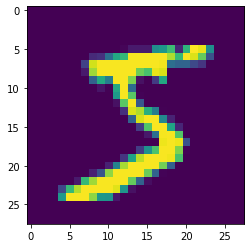

In [56]:
plt.imshow(x[0].reshape(28, 28))

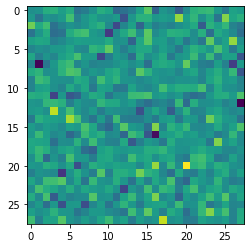

In [57]:
plt.imshow(x_h.numpy()[0].reshape(28, 28))